<a href="https://colab.research.google.com/github/rj7shakya/music_composition/blob/master/music_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!ls '/content/drive/My Drive/beeth'

appass_1.mid		       beethoven_opus10_1.mid  mond_1.mid
appass_2.mid		       beethoven_opus10_2.mid  mond_2.mid
appass_3.mid		       beethoven_opus10_3.mid  mond_3.mid
beethoven_hammerklavier_1.mid  beethoven_opus22_1.mid  pathetique_1.mid
beethoven_hammerklavier_2.mid  beethoven_opus22_2.mid  pathetique_2.mid
beethoven_hammerklavier_3.mid  beethoven_opus22_3.mid  pathetique_3.mid
beethoven_hammerklavier_4.mid  beethoven_opus22_4.mid  waldstein_1.mid
beethoven_les_adieux_1.mid     beethoven_opus90_1.mid  waldstein_2.mid
beethoven_les_adieux_2.mid     beethoven_opus90_2.mid  waldstein_3.mid
beethoven_les_adieux_3.mid     elise.mid


In [2]:
from music21 import *

In [3]:
track=0
# reading midi file 
def read_midi(file):
  print("Loading music file",file)
  notes=[]
  notes_to_parse=None
  midi = converter.parse(file)
  midi = midi[track]
  notes_to_parse = midi.flat.notes

  # s2 = instrument.partitionByInstrument(midi)
  # for part in s2.parts:
  #   if 'Piano' in str(part):
  #     notes_to_parse = part.recurse()
  for element in notes_to_parse:
    if isinstance(element, note.Note):
      notes.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
      notes.append('.'.join(str(n) for n in element.normalOrder))
  
  return np.array(notes)

In [4]:
import os
import numpy as np
path='/content/drive/My Drive/beeth/'

files=[i for i in os.listdir(path) if i.endswith(".mid")]

notes_array = np.array([read_midi(path+i) for i in files])

Loading music file /content/drive/My Drive/beeth/beethoven_opus90_1.mid
Loading music file /content/drive/My Drive/beeth/beethoven_les_adieux_2.mid
Loading music file /content/drive/My Drive/beeth/beethoven_les_adieux_1.mid
Loading music file /content/drive/My Drive/beeth/elise.mid
Loading music file /content/drive/My Drive/beeth/waldstein_1.mid
Loading music file /content/drive/My Drive/beeth/beethoven_opus22_3.mid
Loading music file /content/drive/My Drive/beeth/beethoven_les_adieux_3.mid
Loading music file /content/drive/My Drive/beeth/appass_3.mid
Loading music file /content/drive/My Drive/beeth/beethoven_opus22_4.mid
Loading music file /content/drive/My Drive/beeth/beethoven_opus10_1.mid
Loading music file /content/drive/My Drive/beeth/beethoven_hammerklavier_4.mid
Loading music file /content/drive/My Drive/beeth/beethoven_hammerklavier_2.mid
Loading music file /content/drive/My Drive/beeth/beethoven_hammerklavier_3.mid
Loading music file /content/drive/My Drive/beeth/pathetique_1

In [5]:
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
pitches = unique_notes
vocab_length = len(pitches)  
number_notes = len(notes_)

print(pitches)
print(notes_)

['F#3', '2.6.10', 'F#1', 'B-2', '4.8', '6.9.0', '1.6', '0.3.5', '11.3.6', '2.3', 'E-3', 'E7', 'F#2', '2.4', 'D6', '9.1.3', '1.3.7', '10.0.3', '7.10.0', '9', '1.4.6', '0.4', '9.11.2.5', '1.5', 'C5', '7.0', '3.5.9', '1.4.7', 'C3', '8.11.3', '7.8', 'E2', '11.3', '2.7', '2.5.8.11', '5.10', 'B-1', '4', '10.2.5', '5.7', '8.1', 'B-5', '5.9.11', '1.3.6', 'G3', 'B-4', '11', 'G#2', '9.10', 'B2', '4.7', '5.8.11.1', '6.8', '8.11.1', '5.9', '11.0', '11.2.6', 'F7', '11.2.3', 'E5', '3.6.8', '6.9', '0.3.7', 'E6', 'D5', '2.5.7', '9.0.4', '8.11', '8.11.2', 'C#5', '10.1.4', '5.7.11', '5.8.11', '3.6', '9.0.3.5', '2.5.9', '6.11', '6.8.0', 'B-3', '7', '10.3', '4.9', '6.9.0.2', '2', '6', 'G4', '0.4.7', '3.6.9', '11.2', 'B-6', '9.0', '0.2.6', 'E-2', '6.9.1', '7.11', '3.5', '1.4', 'E-6', '10', '9.0.3', '11.1', 'G5', '6.10', '1.4.7.10', 'C4', '6.9.11', '9.1.4', '0.3.6.9', '4.10', '10.0.5', '10.2.3.5', '2.5.8.10', 'C#4', '10.1', '5', '3.7', '0.6', 'F3', 'B5', 'F5', 'B3', 'G2', '11.2.5.7', '7.9', '1.7', '0.3.6', 

In [6]:
note_dict = dict()
for i, note in enumerate(pitches):
  note_dict[note] = i

sequence_length = 50

num_training = number_notes - sequence_length

input_notes = np.zeros((num_training, sequence_length, vocab_length))
output_notes = np.zeros((num_training, vocab_length))

for i in range(0, num_training):
    # Here, i is the training example, j is the note in the sequence for a specific training example
    input_sequence = notes_[i: i+sequence_length]
    output_note = notes_[i+sequence_length]
    for j, note in enumerate(input_sequence):
        input_notes[i][j][note_dict[note]] = 1
    output_notes[i][note_dict[output_note]] = 1

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization as BatchNorm
from keras.callbacks import ModelCheckpoint

# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, vocab_length)))
# model.add(Dropout(0.2))
# model.add(LSTM(128, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(vocab_length))
# model.add(Activation('softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

model = Sequential()
model.add(LSTM(
    128,
    input_shape=(sequence_length, vocab_length),
    recurrent_dropout=0.3,
    return_sequences=True
))
model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.3,))
model.add(LSTM(128))
model.add(BatchNorm())
model.add(Dropout(0.3))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNorm())
model.add(Dropout(0.3))
model.add(Dense(vocab_length))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)
callbacks_list = [checkpoint]

# model.fit(input_notes, output_notes, epochs=200, batch_size=128, callbacks=callbacks_list)

history = model.fit(np.array(input_notes), np.array(output_notes), batch_size=128, epochs=50)

Epoch 1/50
331/331 [==============================] - 271s 818ms/step - loss: 3.9452 - acc: 0.1263
Epoch 2/50
331/331 [==============================] - 266s 803ms/step - loss: 3.2375 - acc: 0.1595
Epoch 3/50
331/331 [==============================] - 258s 778ms/step - loss: 3.1006 - acc: 0.1711
Epoch 4/50
331/331 [==============================] - 249s 753ms/step - loss: 3.0251 - acc: 0.1812
Epoch 5/50
331/331 [==============================] - 253s 765ms/step - loss: 2.9620 - acc: 0.1980
Epoch 6/50
331/331 [==============================] - 244s 736ms/step - loss: 2.8866 - acc: 0.2312
Epoch 7/50
331/331 [==============================] - 237s 715ms/step - loss: 2.8247 - acc: 0.2559
Epoch 8/50
331/331 [==============================] - 238s 719ms/step - loss: 2.7788 - acc: 0.2692
Epoch 9/50
331/331 [==============================] - 238s 720ms/step - loss: 2.7364 - acc: 0.2850
Epoch 10/50
331/331 [==============================] - 248s 750ms/step - loss: 2.6936 - acc: 0.2960
Epoch 11/

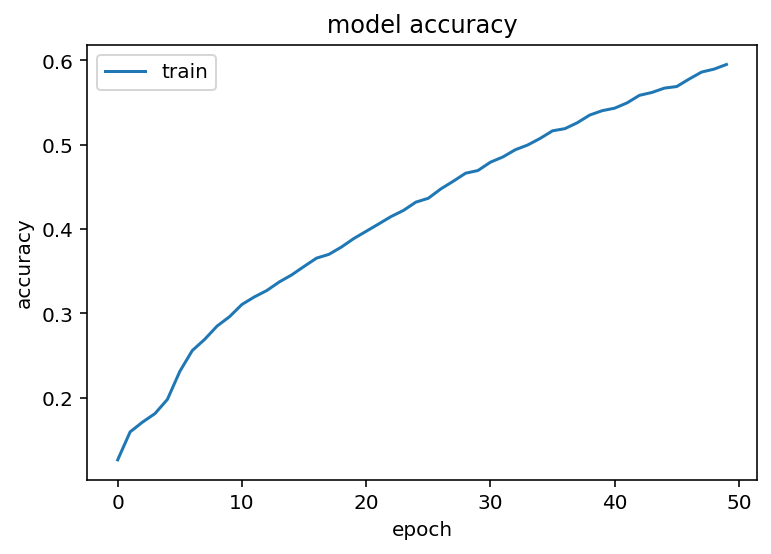

In [8]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 128)           189440    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
activation (Activation)      (None, 128)               0

In [10]:
model.save("music2.hdf5")

In [11]:
# generating music 

backward_dict = dict()
for note in note_dict.keys():
  index = note_dict[note]
  backward_dict[index] = note

n = np.random.randint(0, len(input_notes)-1)
sequence = input_notes[n]
start_sequence = sequence.reshape(1, sequence_length, vocab_length)
output = []

for i in range(0, 100):
  newNote = model.predict(start_sequence, verbose=0)
  # Get the position with the highest probability
  index = np.argmax(newNote)
  encoded_note = np.zeros((vocab_length))
  encoded_note[index] = 1
  output.append(encoded_note)
  sequence = start_sequence[0][1:]
  start_sequence = np.concatenate((sequence, encoded_note.reshape(1, vocab_length)))
  start_sequence = start_sequence.reshape(1, sequence_length, vocab_length)


In [12]:
from music21 import note

finalNotes = [] 
for element in output:
    index = list(element).index(1)
    finalNotes.append(backward_dict[index])
    
offset = 0
output_notes = []

for pattern in finalNotes:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    # increase offset each iteration so that notes do not stack
    offset += 0.5

midi_stream = stream.Stream(output_notes)

midi_stream.write('midi', fp='test_op2.mid')

'test_op2.mid'